<a href="https://colab.research.google.com/github/heejjj/Sleeping_Project/blob/main/ARIMA_total.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터셋 로드

In [46]:
df = pd.read_csv('df.csv').drop(['Unnamed: 0'],axis=1)
df

,ds,y
0,20230221000030,1
1,20230221000100,1
2,20230221000130,1
3,20230221000200,1
4,20230221000230,1
...,...,...
62171,20230503074200,0
62172,20230503074230,0
62173,20230503074300,0
62174,20230503074330,0


# ARIMA

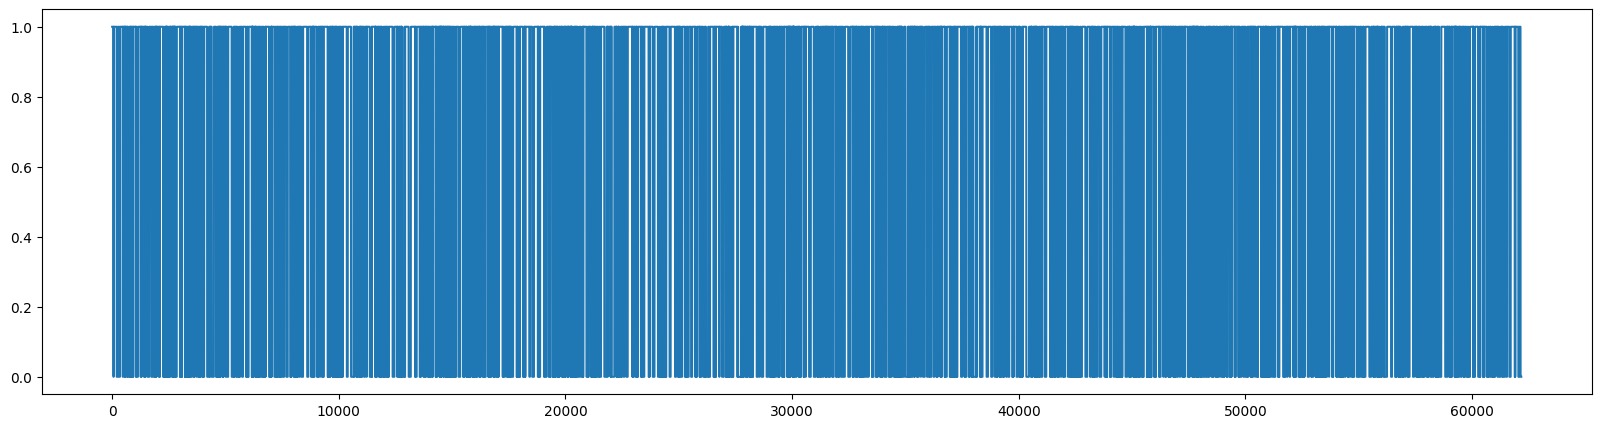

In [36]:
plt.figure(figsize=(20,5))
plt.plot(range(len(df["ds"])), df["y"])
plt.show()

In [37]:
idx = []
for i in range(1,49):
  idx.append(928*i-1)

idx

[927,
 1855,
 2783,
 3711,
 4639,
 5567,
 6495,
 7423,
 8351,
 9279,
 10207,
 11135,
 12063,
 12991,
 13919,
 14847,
 15775,
 16703,
 17631,
 18559,
 19487,
 20415,
 21343,
 22271,
 23199,
 24127,
 25055,
 25983,
 26911,
 27839,
 28767,
 29695,
 30623,
 31551,
 32479,
 33407,
 34335,
 35263,
 36191,
 37119,
 38047,
 38975,
 39903,
 40831,
 41759,
 42687,
 43615,
 44543]

In [38]:
# 훈련 데이터셋 정의
df_train = df.iloc[idx]   # 마지막 수면 단계를 예측하는 것이 목표
df_train

,ds,y
927,20230221074400,1
1855,20230222074400,0
2783,20230223074400,1
3711,20230225074400,1
4639,20230226074400,0
5567,20230227074400,0
6495,20230228074400,1
7423,20230302074400,1
8351,20230303074400,0
9279,20230304074400,1


# 패턴 쪼개기

<Figure size 640x480 with 0 Axes>

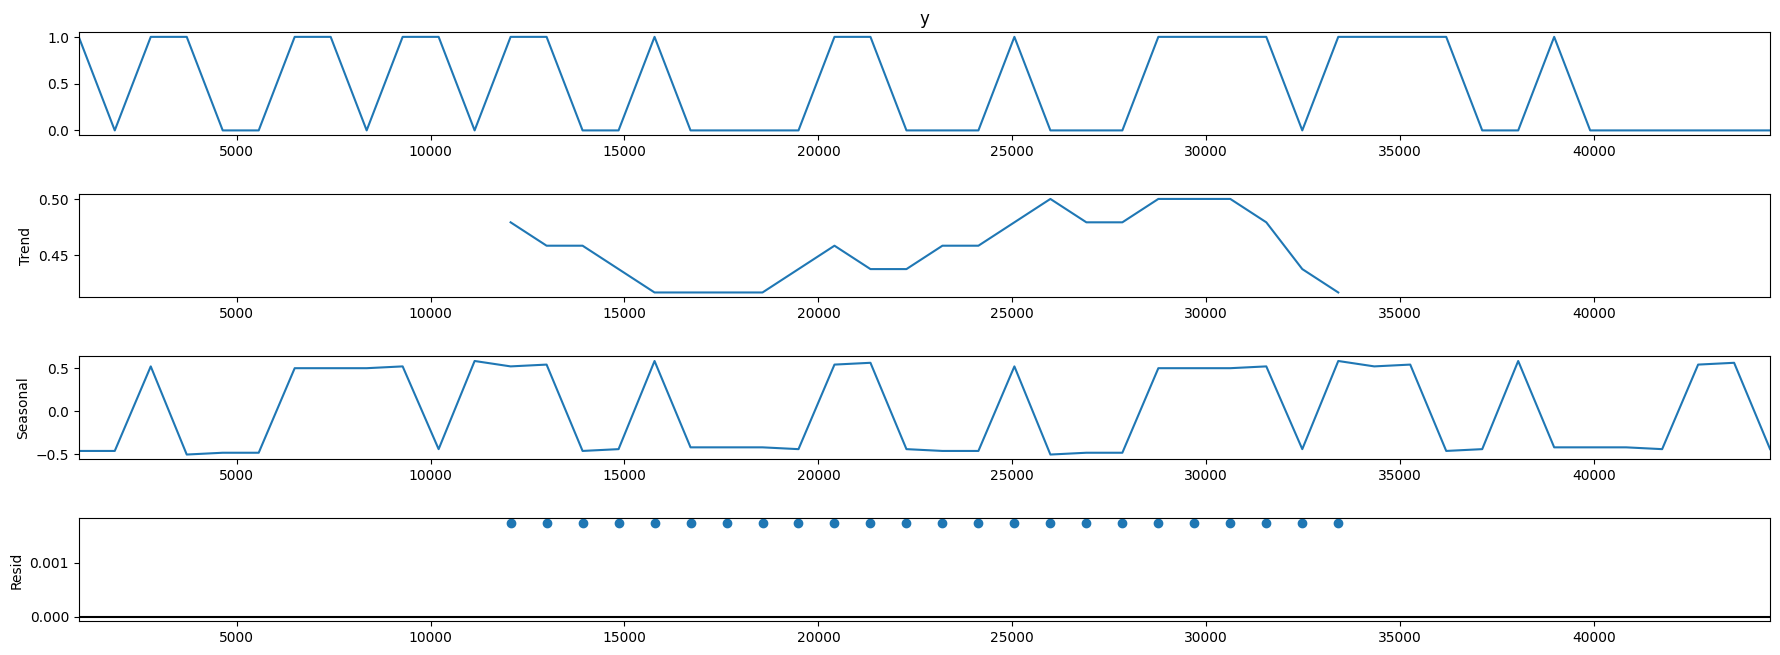

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_train['y'], model="additive", period=24)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,7)
plt.show()

In [ ]:
# 특정 주기는 없어 보임..Trend와 Seasonal을 보는 것이 맞는지
# Resid가 모두 0.001 이상.

# ACF, PACF

- 상관도표(Correlogram)는 autocorrelation function(ACF)와 partial autocorrelation function(PACF) 중 하나를 그래프로 표현한 것.
- Correlogram을 활용하여 현 시점의 자료와 시점의 차이(lag)를 가지는 자료를 비교하여 어떤 관계를 가지고 있는지를 분석할 수 있음. 
- 즉, Correlogram을 활용하여 시점의 차이의 영향력을 알아볼 수 있습니다.

https://direction-f.tistory.com/65

## [자기상관함수(Autocorrelation Fucntion, ACF)]

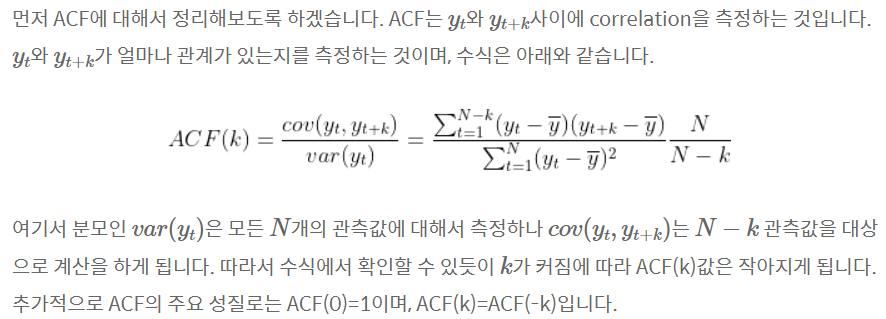

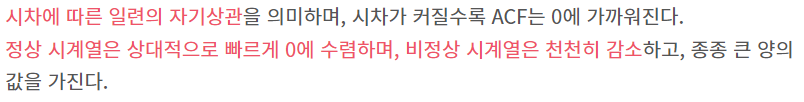


## [편자기상관함수(Partial Autocorrelation Fucntion, PACF)]

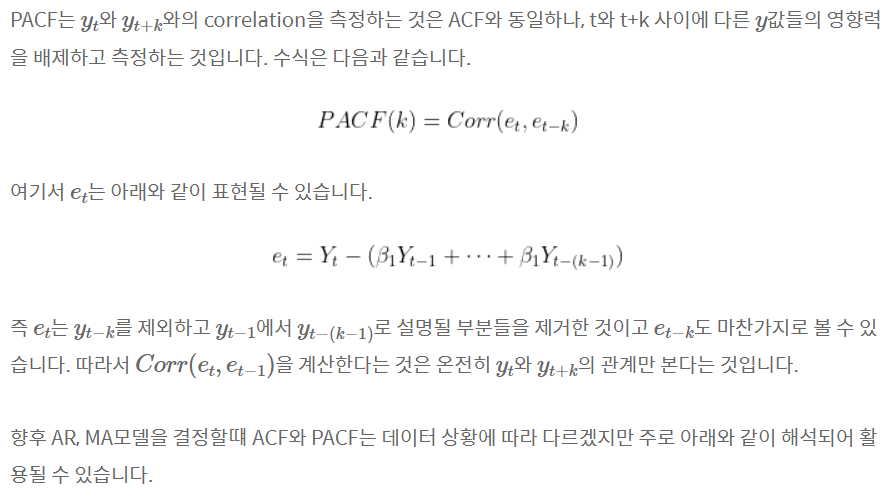

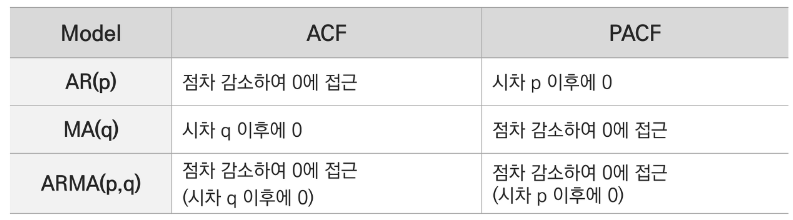

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


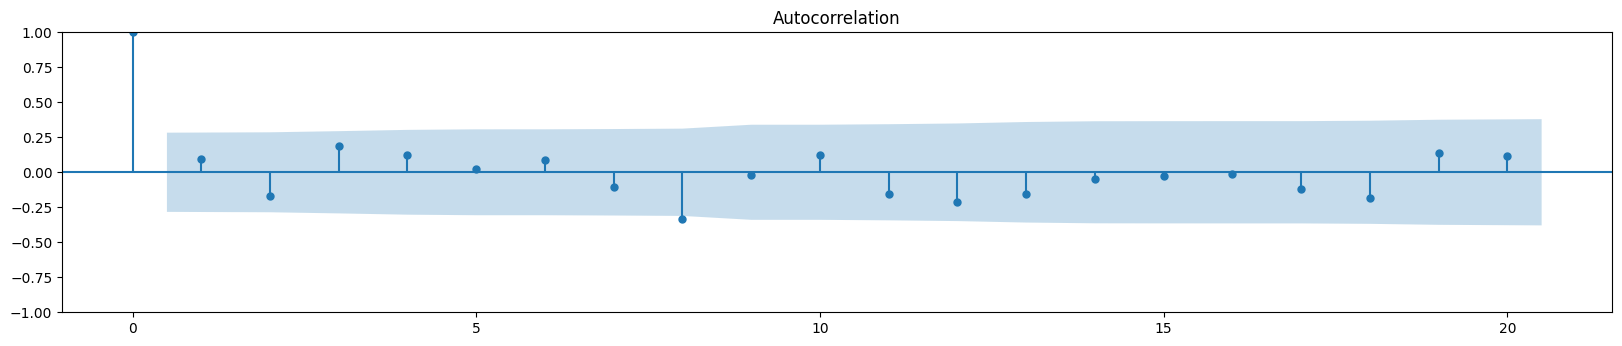

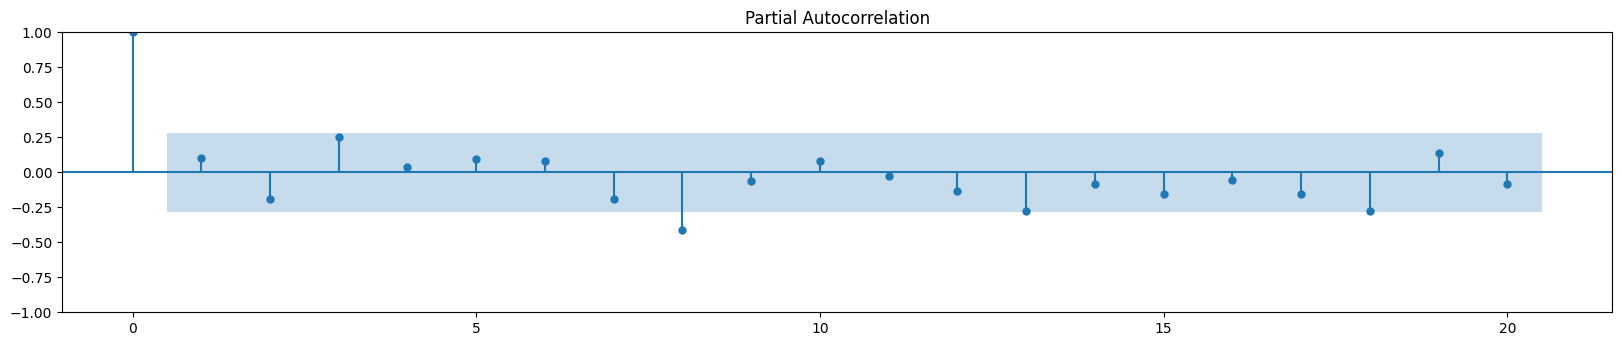

In [40]:
import statsmodels.api as sm
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train["y"], lags=20, ax=ax1)   # correlation 과 신뢰구간. 

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train["y"], lags=20, ax=ax1)

In [ ]:
# ACF 안정적임. 정상 시계열. q = 1
# PACF q = 1


# Modeling, Training, Evaluate

In [41]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from tqdm import tqdm

- 최적의 파라미터를 찾기 위해 위에서 구한 범위에 들어가도록 grid search를 진행.

In [42]:
p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))

aic = []
params = []

with tqdm(total = len(pdq)) as pg:
    for i in pdq:
        pg.update(1)
        try:
            model = ARIMA(df_train["y"], order=(i))
            model_fit = model.fit()
            aic.append(round(model_fit.aic,2))
            params.append((i))
        except:
            continue

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g

- 9개의 파라미터들에 대한 탐색 진행

In [43]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
model_opt = ARIMA(df_train["y"], order = optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -33.856
Date:                Sun, 11 Jun 2023   AIC                             75.712
Time:                        16:16:00   BIC                             83.113
Sample:                             0   HQIC                            78.497
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1703      0.177     -0.964      0.335      -0.517       0.176
ar.L2         -0.4307      0.241     -1.789      0.074      -0.903       0.041
ma.L1         -0.5694      0.228     -2.493      0.013      -1.017      -0.122
sigma2         0.2408      0.095      2.545      0.011       0.055       0.426
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.94   Prob(JB):                         0.20
Heteroskedasticity (H):               1.19   Skew:                             0.22
Prob(H) (two-sided):                  0.74   Kurtosis:                         1.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- 탐색된 파라미터들 중 aic가 가장 낮은 모델을 최적의 모델로 선택하였다.
- 최적의 파라미터는 (2,1,1) 이고 모델 학습의 결과는 위와 같다.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ValueError: ignored

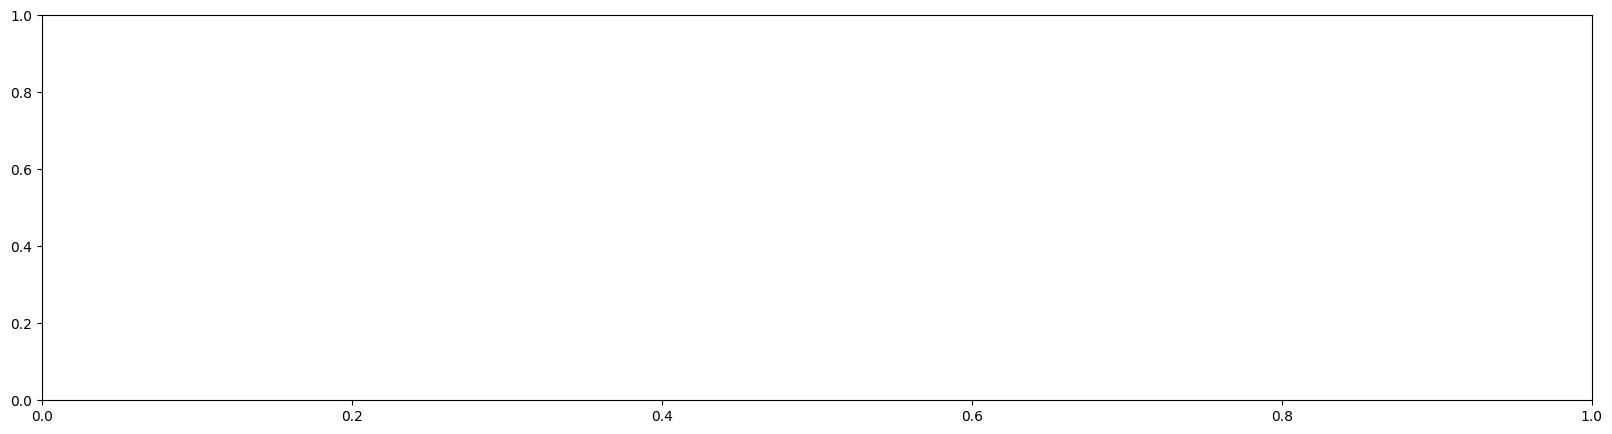

In [44]:
# model = ARIMA(df_train["y"], order=optimal[0][0])
# model_fit = model.fit()
# forecast = model_fit.forecast(steps=24*7)  # 일주일을 예측하는 것이 아니라 하루의 마지막 수면 단계를 예측하는 것으로 하려면 어떻게 해야할까..?

# plt.figure(figsize=(20,5))
# plt.plot(range(200,744), df["y"].iloc[400:])
# plt.plot(forecast)